# OpenCV Implementation for Stereo Reconstruction 

In [3]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

## Disparity Calculation using OpenCV

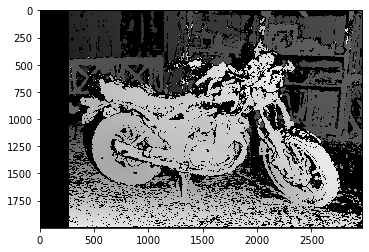

<Figure size 1152x864 with 0 Axes>

In [20]:
imgL_color = cv2.imread('datasets/Motorcycle-perfect/im0.png')
imgR_color = cv2.imread('datasets/Motorcycle-perfect/im1.png')

imgL = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2GRAY)

#stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
stereo = cv2.StereoBM_create(numDisparities=256, blockSize=21)
disparity = stereo.compute(imgL, imgR)

disparity = np.float32(disparity)
disparity = disparity * 1.0 / 16.0

#norm_coeff = 255 / disparity.max()
#cv2.imshow("disparity", disparity * norm_coeff / 255)

plt.imshow(disparity, cmap='gray')
plt.figure(figsize=(16, 12))
plt.show()

## 3D World Coordinates using OpenCV

In [70]:
baseline = 193.001

Q = np.array([  [1, 0, 0, -1244.772],
                [0, 1, 0, -1019.507],
                [0, 0, 0, 3979.911],
                [0, 0, -1/baseline, (1244.772-1369.115)/baseline] ])

In [71]:
points = cv2.reprojectImageTo3D(disparity, Q)

In [72]:
f = open('python.off', 'w')

f.write("OFF\n")
f.write(str(points.shape[0] * points.shape[1]) + " 0 0\n")

for i in range(points.shape[0]):
    for j in range(points.shape[1]):
        point = points[i][j]
        f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + "\n")
        
f.close()

In [43]:
f = open('python.off', 'w')

f.write("COFF\n")
#f.write(str(np.sum(np.absolute(count_points[:, 2]))) + " 0 0\n")
f.write(str(len(points)) + " 0 0\n")

for point in points:
    #if np.absolute(point[2][0]) < 10:
#     f.write(str(point[0][0]) + " " + str(point[1][0]) + " " + str(point[2][0]) + "\n")
    f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + "\n")
      
f.close()

In [51]:
focal_length = 3979.911 
baseline = 193.001

# focal_length = 1740.01245  
# baseline = 100


intrinsics = np.array([[3979.911, 0.0, 1244.772],
              [0.0, 3979.911, 1019.507],
              [0.0, 0.0, 1.0]])

intrinsics_2 = np.array([[3979.911, 0.0, 1244.772],
              [0.0, 3979.911, 1019.507],
              [0.0, 0.0, 1.0]])


# intrinsics = np.array([[1740.01245, 0.0, 779.601468],
#                          [0.0, 1742.12231, 1138.81797],
#                          [0.0, 0.0, 1.0]])

# intrinsics_2 = np.array([[1612.98267, 0.0, 778.885092],
#                          [0.0, 1642.61304, 1083.29674],
#                          [0.0, 0.0, 1.0]])


intrinsics_inverse = np.linalg.inv(intrinsics)

## Vertices and Faces

In [52]:
points = []

Q03 = -intrinsics[0, 2]
Q13 = -intrinsics[1, 2]
Q23 = focal_length
Q32 = -1.0 / baseline
Q33 = (intrinsics[0, 2] - intrinsics_2[0, 2]) / baseline

for i in range(disparity.shape[0]):
    for j in range(disparity.shape[1]):
        if disparity[i, j] > 0:
            #2964.0 *
            #z = focal_length * baseline / (disparity[i, j])
            #x = float(j) * z / focal_length
            #y = float(i) * z / focal_length
            pw = 1.0 / (disparity[i, j] * Q32 + Q33)
            z = Q23 * pw
            x = (float(j) + Q03) * pw
            y = (float(i) + Q13) * pw
            (color_b, color_g, color_r) = imgL_color[i, j]
            
            #point = z * np.dot(intrinsics_inverse, np.array([[j], [i], [1]]))
    #             point =np.dot(z * intrinsics_inverse, np.array([[j], [i], [1]]))
            #point = np.dot(intrinsics_inverse, np.array([x, y, z]))
            point = np.array([x, y, z, color_r, color_g, color_b])
            points.append(point)

In [53]:
faces = []
edgeThreshold = 10

for idx in range(len(points)-2):
    
    pt1 = points[idx]
    pt2 = points[idx+1]
    pt3 = points[idx+2]
    
    len1 = np.linalg.norm(pt1-pt2)
    len2 = np.linalg.norm(pt1-pt3)
    len3 = np.linalg.norm(pt2-pt3)
    
    if(len1 + len2 + len3) <= edgeThreshold:
        faces.append(np.array([idx, idx+1, idx+2]))

In [54]:
print(len(points))
print(len(faces))

326465

In [56]:
count_points = np.array(points)

f = open('python.off', 'w')

f.write("COFF\n")
#f.write(str(np.sum(np.absolute(count_points[:, 2]))) + " 0 0\n")
f.write(str(len(points)) + " 0 0\n")

for point in points:
    #if np.absolute(point[2][0]) < 10:
    #f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + "\n")
    f.write(str(point[0]) + " " + str(point[1]) + " " + str(point[2]) + " " + str(int(point[3])) + " " + str(int(point[4])) +" " + str(int(point[5])) + " 255 \n")

for face in faces:
    f.write(str(face[0]) + " " + str(face[1]) + " " + str(face[2]) + "\n")
    
f.close()